# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [104]:
!pip install fast_ml
import pandas as pd # импортируем библиотеку pandas
from fast_ml.model_development import train_valid_test_split # библиотека для разделения данных на выборки
from sklearn.tree import DecisionTreeClassifier # Дерево решений
from sklearn.ensemble import RandomForestClassifier # Случайный лес
from sklearn.linear_model import LogisticRegression # Логистическая регрессия
from sklearn.model_selection import RandomizedSearchCV # библиотека перебора гиперпараметров
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # библиотека для проверки моделей
from scipy.stats import randint # генератор случайных чисел

data = pd.read_csv('/datasets/users_behavior.csv') # считываем файл
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


В датасете присутствует 3214 строк и 5 столбцов:
- `calls` — количество звонков;
- `minutes` — суммарное время разговоров в минутах;
- `messages` — количество отправленных сообщений;
- `mb_used` — количество использованных МБ интернета;
- `is_ultra` — принадлежность к тарифу (0 — `"Смарт"`, 1 — `"Ультра"`).

Проверим типы данных

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Количество звонков и отправленных сообщений можно привести к целочисленному типу.

In [106]:
data[['calls', 'messages']] = data[['calls', 'messages']].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Проверим пропуски и дубликаты.

In [107]:
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Пропусков нет.

In [108]:
data.duplicated().sum()

0

Полностью одинаковых строк тоже нет.

Оценим датасет по гистограммам.

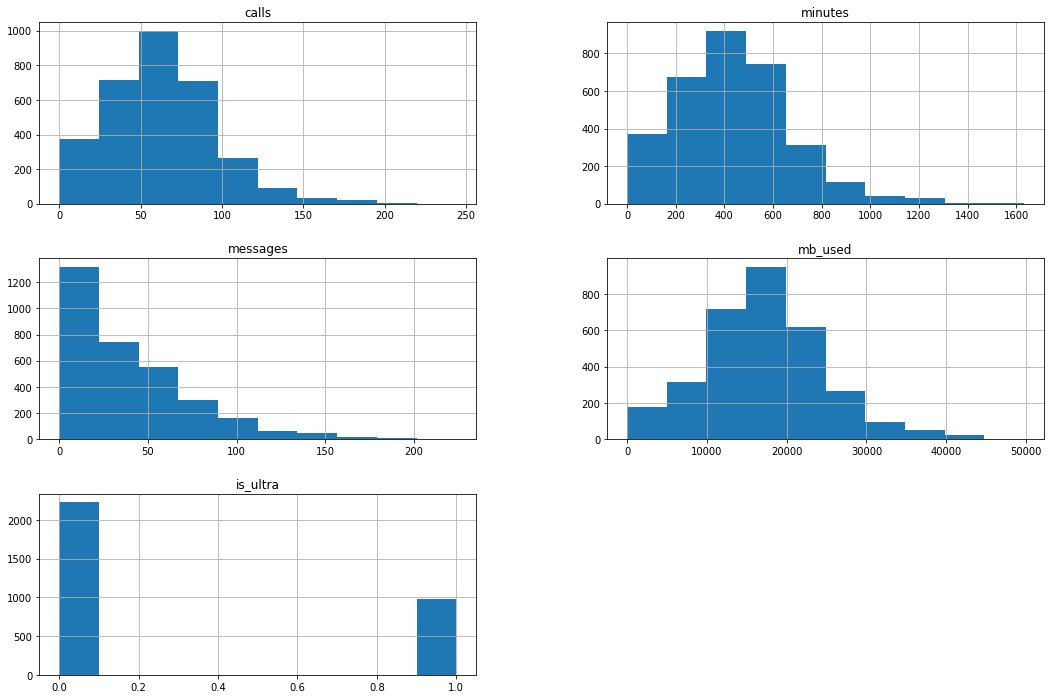

In [109]:
data.hist(figsize=(18, 12));

Сходу можно сказать, что большинство клиентов в месяц:
- делают в основном до 100 звонков;
- тратят на звонки до 800 минут;
- отправляют до 100 сообщений;
- используют до 30 тысяч мегабайт интернета;
- используют тариф "Смарт".

Оценим медианные показатели пользователей в зависимости от тарифа.

In [110]:
data.groupby('is_ultra').median()

,calls,minutes,messages,mb_used
is_ultra,,,,
0,60,410.56,28,16506.93
1,74,502.55,38,19308.01


Пользователи с тарифом "Ультра" пользуются услугами связи и общения значительно больше, чем пользователи с тарифом "Смарт".

## Разбейте данные на выборки

Разделим выборку на обучающую, валидационную и тестовую. Целовой признак — тариф.

In [111]:
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(
    data, target='is_ultra', train_size=0.6, valid_size=0.2, test_size=0.2, method='random', random_state=12345)

## Исследуйте модели

Перед нами стоит задача классификации, обучим три разные модели и посмотрим какая из них будет лучше.

### Дерево решений

Обучим модель "Дерево решений" с различными гиперпараметрами и определим наилучшее `accuracy`.

In [112]:
param_dist = {'max_depth': list(range(1, 11)), # перебираем гиперпараметры
             'min_samples_leaf': randint(1, 9),
             'criterion' : ['gini', 'entropy']}
tree_model = DecisionTreeClassifier() # создаем модель дерево решений
tree_cv = RandomizedSearchCV(tree_model, param_dist, cv=5, random_state=12345) # ищем лучшие гиперпараметры
tree_cv.fit(x_train, y_train) 
print('Лучшие гиперпараметры:', tree_cv.best_params_)

Лучшие гиперпараметры: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 6}


Пройдем валидацию обученной модели. Результат проверим при помощи Confusion Matrix.

In [113]:
y_pred = tree_cv.predict(x_valid)
cm = confusion_matrix(y_pred, y_valid)
cm

array([[430, 117],
       [ 24,  72]])

Правильных значений получилось 502 из 643. Найдем `accuracy`.

In [114]:
tree_cv.score(x_valid, y_valid)

0.7807153965785381

`Accuracy` составила 78%.

### Случайный лес

Обучим модель "Случайный лес" с различными гиперпараметрами.

In [115]:
param_dist = {'n_estimators' : list(range(1, 20)),
              'max_depth': list(range(1, 11)),
             'min_samples_leaf': randint(1, 9)}
forest_model = RandomForestClassifier()
forest_cv = RandomizedSearchCV(forest_model, param_dist, cv=5, random_state=12345)
forest_cv.fit(x_train, y_train)
print('Лучшие гиперпараметры:', forest_cv.best_params_)

Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 17}


Проверим на матрице.

In [116]:
y_pred = forest_cv.predict(x_valid)
cm = confusion_matrix(y_pred, y_valid)
cm

array([[419,  96],
       [ 35,  93]])

Правильных значений получилось 509 из 643.

In [117]:
forest_cv.score(x_valid, y_valid)

0.7962674961119751

Значение `accuracy` — 79%.

### Логистическая регрессия

Обучим модель "Логистической регрессии" с количеством итераций 1000.

In [118]:
log_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
log_model.fit(x_train, y_train)
print('Значение "accuracy":', log_model.score(x_valid, y_valid))

Значение "accuracy": 0.7107309486780715


Модель "Логистическая регрессия" дала результат более 71% правильности.

**Наилучший результат показала модель обучения "Случайный лес". Значение "accuracy" составило более 79% правильности.**

## Тестирование моделей

Проверим `Дерево решений` на тестовой выборке.

In [119]:
print('Значение "accuracy":', tree_cv.score(x_test, y_test))

Значение "accuracy": 0.7838258164852255


Правильность составила 78%. Теперь проверим `Случайный лес`.

In [120]:
print('Значение "accuracy":', forest_cv.score(x_test, y_test))

Значение "accuracy": 0.80248833592535


На тестовой выборке модель показала 80% правильности. Осталось проверить `Логистическую регрессию`.

In [121]:
print('Значение "accuracy":', log_model.score(x_test, y_test))

Значение "accuracy": 0.6842923794712286


Правильность составила 68%.

## Проверьте модели на адекватность

Оценим, как делает предсказания наша лучшая модель. Мы будем использовать матрицу, по которой сможем оценить, как классифицирует данные наша модель.

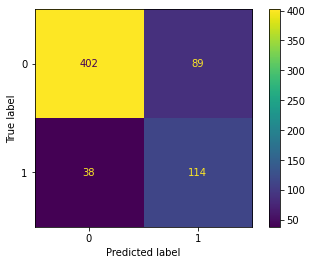

In [122]:
y_pred = forest_cv.predict(x_test) # делаем предсказания на тестовой выборке
cm = confusion_matrix(y_pred, y_test) # создаем матрицу
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_cv.classes_) # визуализация
disp.plot();

Модель правильно предсказала 405 клиентов, которые пользуются тарифом "Smart" и 110 клиентов на тарифе "Ultra". В первом тарифе было сделано 93 ошибки, во втором 35.

## Выводы

В данной работе был рассмотрен датасет клиентов мобильной связи. Было известно месячное количество звонков, отправленных сообщений, общее время звонков и использованные мегабайты интернета, а также принадлежность к одному из двух тарифов: "Smart" и "Ultra".

Был проведен небольшой анализ данных, удалось выяснить, что большинство клиентов в месяц:
- делают в основном до 100 звонков;
- тратят на звонки до 800 минут;
- отправляют до 100 сообщений;
- используют до 30 тысяч мегабайт интернета;
- используют тариф "Смарт".

Также выяcнилось, что клиенты с тарифом "Ultra" больше пользуются услугами связи во всех отношениях.

В проекте была поставлена задача обучить модель, которая сможет определять тариф клиента, на основе того, как он пользуется услугами связи.

Было рассмотрено три модели, которые решали задачу классификации: "Дерево решений", "Случайный лес", "Логистическая регрессия". Они дали результат правильности соответственно: 78%, 80%, 68%. С небольшим отрывом модель "Случайный лес" показала наилучший результат.

Модель "Случайный лес" была проверена на адекватность. Она правильно определила пользователей тарифа "Smart" в 405 случаях из 498, а для клиентов тарифа "Smart" 110 из 145.

Лучшая обученная модель позволит определять наиболее подходящий тариф для клиента с точностью 80%, опираясь на то, как он пользуется услугами связи.